# Predict  an Average Annual Salary 2023 for a Job Position


## 2023 Developer Survey conducted by Stack Overflow

In May 2023 over 90,000 developers responded to the annual survey about how they learn and level up, which tools they're using, and which ones they want. Here we explore developer profile and programming, scripting, and markup languages developers used in 2023. The goal is to figure out high-paying professionals and their programming preferences.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random

from matplotlib import pyplot as plt

import sys
sys.path.append("../src")

from config import url2023, url2024, file_name
from data.load_data import get_data
from data.clean_data import dataset_cleaned

# load row data
df = get_data(url2023, file_name)

# cleaned subset of the data
cdf = dataset_cleaned(df)

In [2]:
# load row data for 2024
df2024 = get_data(url2024, file_name)

# cleaned subset of the data for 2024
cdf2024 = dataset_cleaned(df2024)

## Remove outliers

In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()
rscaler = RobustScaler()

outlier_threshold = 3

# calculate Z-score for annual salary
Zscore = pd.Series(scaler.fit_transform(cdf[["ConvertedCompYearly"]]).reshape(-1), index=cdf.index )

# calculate Z-score for annual salary using robust percentile measures
Zrscore = pd.Series(rscaler.fit_transform(cdf[["ConvertedCompYearly"]]).reshape(-1), index=cdf.index )

# define outliers based on Zscore
#fltr_outliers = Zscore.apply(lambda x: (x > outlier_threshold) or (x < -outlier_threshold))

# define outliers based on Zscore robust
fltr_outliers = Zrscore.apply(lambda x: (x > outlier_threshold) or (x < -outlier_threshold))

# remove outliers from dataset
cdf = cdf.loc[~fltr_outliers]

In [4]:
# delete outliers from data for 2024
Zrscore2024 = pd.Series(rscaler.fit_transform(cdf2024[["ConvertedCompYearly"]]).reshape(-1), index=cdf2024.index )
fltr_outliers2024 = Zrscore2024.apply(lambda x: (x > outlier_threshold) or (x < -outlier_threshold))
cdf2024 = cdf2024.loc[~fltr_outliers2024]

## Average Annual Salary depends on Job Position

In [5]:
# aggregated data by job positions

dfposition = cdf.groupby(["DevType","YearsCodePro"]).ConvertedCompYearly.mean().reset_index(level=1)
dfposition2024 = cdf2024.groupby(["DevType","YearsCodePro"]).ConvertedCompYearly.mean().reset_index(level=1)

In [6]:
# choose randomly a position from the list available in both train and test sets

#random.seed(263)

positions_train = set(dfposition.index.unique())
positions_test = set(dfposition2024.index.unique())

positions = list(positions_test.intersection(positions_train))

position = positions[random.randint(0, len(positions)-1)]

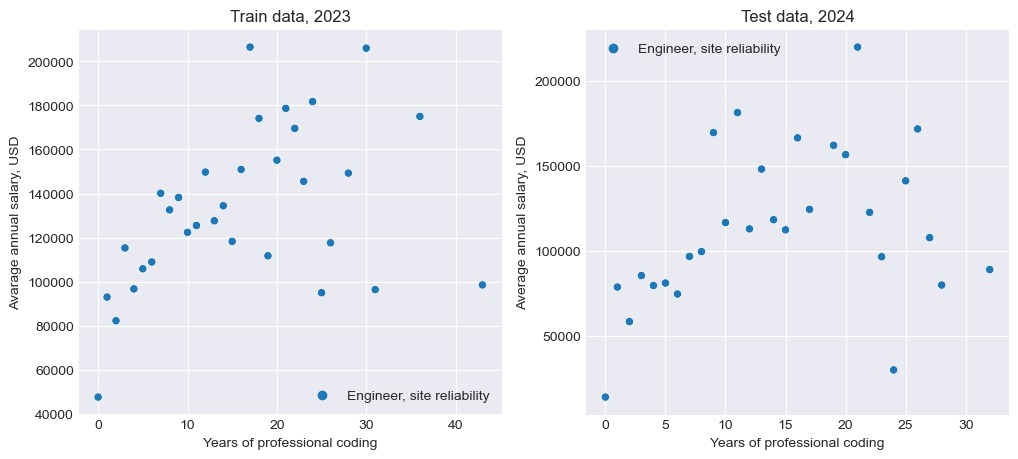

In [7]:
plt.style.use("seaborn-darkgrid")

width=12
height=5

fig = plt.figure(figsize=(width, height))
fig.tight_layout()

ax1 = fig.add_subplot(121)
sns.scatterplot(x="YearsCodePro", y="ConvertedCompYearly",
                data=dfposition.loc[position],
                hue=dfposition.loc[position].index, ax=ax1)
plt.legend(title="")
plt.xlabel("Years of professional coding")
plt.ylabel("Avarage annual salary, USD")
plt.title("Train data, 2023")


ax2 = fig.add_subplot(122)
sns.scatterplot(x="YearsCodePro", y="ConvertedCompYearly",
                data=dfposition2024.loc[position],
                hue=dfposition2024.loc[position].index, ax=ax2)
plt.legend(title="")
plt.xlabel("Years of professional coding")
plt.ylabel("Average annual salary, USD")
plt.title("Test data, 2024")

plt.show()
plt.close()

## Polynomial regression

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [9]:
X_train = dfposition.loc[position, "YearsCodePro"]
y_train = dfposition.loc[position, "ConvertedCompYearly"]

X_test = dfposition2024.loc[position, "YearsCodePro"]
y_test = dfposition2024.loc[position, "ConvertedCompYearly"]

In [10]:
# polynomial degree for regression
polinomial_degree = 2

In [11]:
# fit a model on the train data set
features_poly = PolynomialFeatures(degree=polinomial_degree)

X_train_poly = features_poly.fit_transform(X_train.values.reshape(-1, 1))

model = LinearRegression()
model.fit(X_train_poly, y_train)

R2_train = model.score(X_train_poly, y_train)

In [12]:
# predict salary with the trained model on the test data set
X_test_poly = features_poly.transform(X_test.values.reshape(-1, 1))
y_pred = model.predict(X_test_poly)

RSS = ((y_test-y_pred)**2).sum()
TSS = ((y_train.mean()-y_test)**2).sum()

R2_test = 1.0 - RSS/TSS

In [13]:
print('\nRegression Model')
print(f'Polinomial degree = {polinomial_degree}')
print("\nModel performance on train data R^2 = {}".format(round(R2_train,4)))
print("\nModel performance on test data R^2 = {}".format(round(R2_test,4)))


Regression Model
Polinomial degree = 2

Model performance on train data R^2 = 0.439

Model performance on test data R^2 = 0.2509



Regression Model

Polinomial degree = 2
Model performance on test data R^2 = 0.25086785522758626
Baseline model prediction 132824.05956279475
RSS = 52720264765.514244
TSS = 70375120242.01105


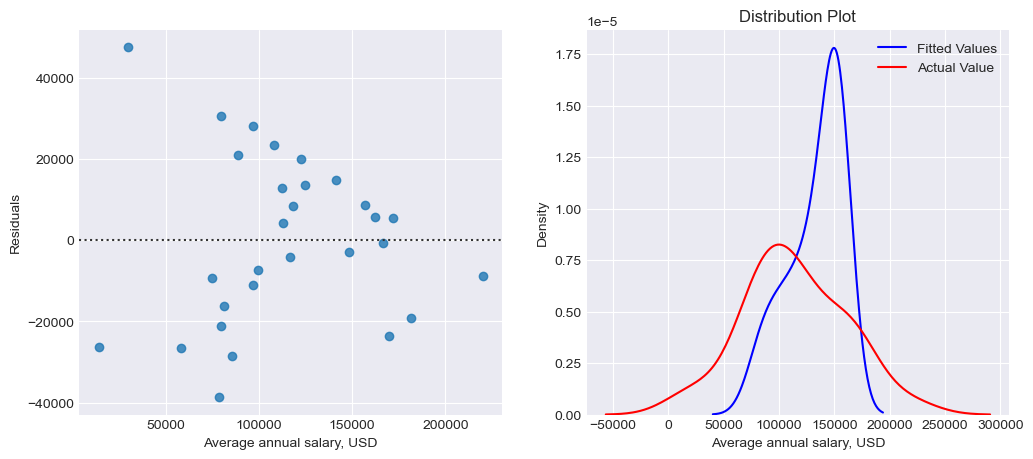

In [14]:
# Evaluate model performance on test data

print('\nRegression Model\n')
print(f'Polinomial degree = {polinomial_degree}')
print("Model performance on test data R^2 = {}".format(R2_test))
    
print("Baseline model prediction {}".format(y_train.mean()))
print("RSS = {}".format(RSS))
print("TSS = {}".format(TSS))

fig = plt.figure(figsize=(width, height))
ax1 = fig.add_subplot(121)
sns.residplot(x=y_test, y=y_pred)
plt.xlabel("Average annual salary, USD")
plt.ylabel("Residuals")

ax2 = fig.add_subplot(122)
sns.kdeplot(y_pred, color="b", label="Fitted Values")
sns.kdeplot(y_test, color="r", label="Actual Value")
ax2.legend()
plt.title("Distribution Plot")
plt.xlabel("Average annual salary, USD")

plt.show()
plt.close()

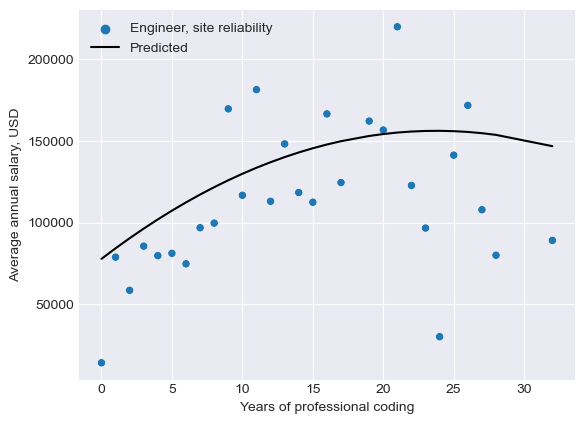

In [15]:
ax = plt.gca()

sns.scatterplot(x="YearsCodePro", y="ConvertedCompYearly",
                data=dfposition2024.loc[position],
                hue=dfposition2024.loc[position].index, ax=ax)
sns.lineplot(x=dfposition2024.loc[position, "YearsCodePro"], y=y_pred, color="black", label="Predicted", ax=ax)

plt.ylabel("Average annual salary, USD")
plt.xlabel("Years of professional coding")
plt.legend(title="")

plt.show()
plt.close()